In [1]:
#Importing relevant libraries and setting plotstyles:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set_style("dark")

In [2]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [3]:
#Connecting to BigQuery:
from google.cloud import bigquery
project_id = "projeto-01-403615"
client = bigquery.Client(project=project_id)

In [4]:
#Query the database to retrieve the table and converting to a Pandas DataFrame:
query = """
SELECT
  *
FROM
  `bigquery-public-data.chicago_crime.crime`
"""
df_total = client.query(query).to_dataframe()

## Data Cleaning

In [5]:
#Inspecting the dataframe
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8165936 entries, 0 to 8165935
Data columns (total 22 columns):
 #   Column                Dtype              
---  ------                -----              
 0   unique_key            Int64              
 1   case_number           object             
 2   date                  datetime64[us, UTC]
 3   block                 object             
 4   iucr                  object             
 5   primary_type          object             
 6   description           object             
 7   location_description  object             
 8   arrest                boolean            
 9   domestic              boolean            
 10  beat                  Int64              
 11  district              Int64              
 12  ward                  Int64              
 13  community_area        Int64              
 14  fbi_code              object             
 15  x_coordinate          float64            
 16  y_coordinate          float64       

In [6]:
#Cheking for null values in the dataframe
df_total.isnull().sum()

,0
unique_key,0
case_number,0
date,0
block,0
iucr,0
primary_type,0
description,0
location_description,13589
arrest,0
domestic,0


## Analysis

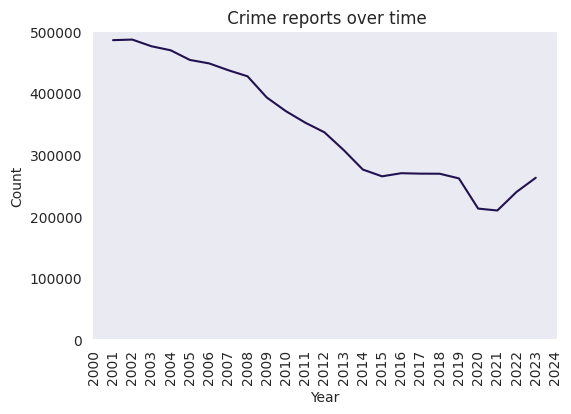

In [7]:
#Analysing incidents of crime reported from 01/01/2001 to 31/12/2023

crime_over_time = df_total.groupby('year')['unique_key'].count().reset_index()
crime_over_time = crime_over_time[:-1]

sns.set_palette("magma")
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.lineplot(data=crime_over_time, x='year', y='unique_key')
ax.set_title(' Crime reports over time')
ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.set(ylim=(0, 500000))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.xticks(rotation=90)
plt.show()

In [8]:
#Calculating the number of incidents of crime reported per hour
crimes_2001 = df_total[df_total['year'] == 2001]['unique_key'].count()
crimes_2001_hour = crimes_2001 / (24*365)

crimes_2023 = df_total[df_total['year'] == 2023]['unique_key'].count()
crimes_2023_hour = crimes_2023 / (24*365)

crimes_2020 = df_total[df_total['year'] == 2020]['unique_key'].count()
crimes_2020_hour = crimes_2020 / (24*365)

print(f"Reports per hour in 2001: {crimes_2001_hour:.2f}")
print(f"Reports per hour in 2023: {crimes_2023_hour:.2f}")
print(f"Reports per hour in 2020: {crimes_2020_hour:.2f}")

Reports per hour in 2001: 55.47
Reports per hour in 2023: 29.97
Reports per hour in 2020: 24.26


###Analysing crime in Chicago over time:
Since I'm dealing with complete years I've removed incomplete data referred to 2024. We can see that crime reports have been decreasing since 2001, with crime rates declining by 46%. To better understand what that means, in 2001 there were more than 55 reports every hour. In 2023, the same metrics were close to 30 reports per hour.

In 2020 and 2021 we see the lowest numbers, 19% less than in 2019, a result of the pandemic and the lockdown, and in 2023 the numbers went back to parameters pre-COVID.


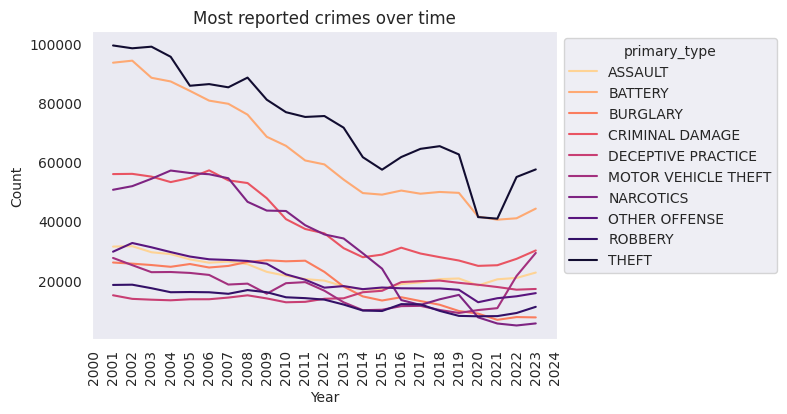

In [9]:
#Analysing the 10 most common crimes  over the years
common_crimes = df_total['unique_key'].groupby(df_total['primary_type']).count().sort_values(ascending=False).head(10)
common_crimes = pd.DataFrame(common_crimes).reset_index()

cc = common_crimes['primary_type'].tolist()

cc_year = df_total[df_total['primary_type'].isin(cc)].groupby(['year', 'primary_type'])['unique_key'].count()
cc_year = pd.DataFrame(cc_year)
cc_year.reset_index(inplace=True)
cc_year = cc_year[cc_year['year'] != 2024]

ax = sns.set_palette("magma")
ax = plt.subplots(figsize=(6, 4))
ax = sns.lineplot(data=cc_year, x='year', y='unique_key', hue='primary_type', palette='magma_r')
ax.set_title('Most reported crimes over time')
ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.xticks(rotation=90)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

Breaking down the most common types of crimes, the overall downward trend varies in various degrees. Two standouts are theft and motor vehicle theft, which have been increasing rapidly since 2021. Incidents of theft have been reported to numbers comparable to before the pandemic. On the other hand, motor vehicle theft numbers go back almost ten years.


In [10]:
#Checking for null values in the comunity_area column for the year of 2023
df_total['community_area'][df_total['year'] == 2023].isnull().sum()

0

In [11]:
#Selecting only the data related to the year of 2023
df = df_total[df_total['year'] == 2023]

For the scope of this project, I chose to isolate the data related to the year 2023.


30.96% increase in crime rate from bottom to top months.



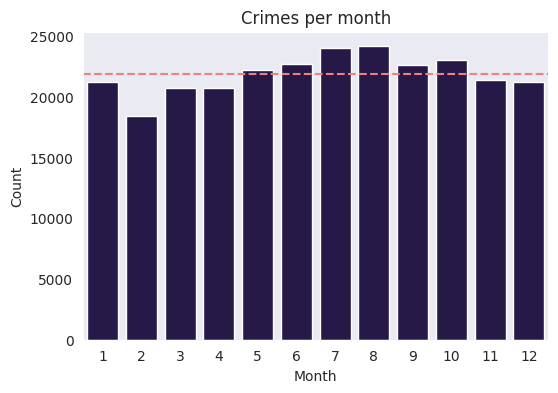

In [12]:
#Dritibuting the reports over the months and calculating the difference between months with the highest and lowest numbers of reports
months = df['unique_key'].groupby([df['date'].dt.month]).count()
months = months[months.index.get_level_values(0) != 2024]

diff = (months.max() - months.min()) / months.min() * 100

avg_crime_per_month = df['unique_key'].count()/12

print(f"{diff:.2f}% increase in crime rate from bottom to top months.")
print()

ax = plt.subplots(figsize=(6, 4))
sns.barplot(x=months.index, y=months.values)
plt.title('Crimes per month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.axhline(y=avg_crime_per_month, color='lightcoral', linestyle='--')
plt.show()

In [13]:
#Top 10 most frequent primary types of crime reported in 2023
crime_type_2023 = df['unique_key'].groupby(df['primary_type']).count().sort_values(ascending=False).head(10)
crime_type_2023 = crime_type_2023.reset_index()
crime_type_2023['percentage'] = ((crime_type_2023['unique_key'] / crime_type_2023['unique_key'].sum()) * 100).round(2)
crime_type_2023

,primary_type,unique_key,percentage
0,THEFT,57440,23.59
1,BATTERY,44207,18.16
2,CRIMINAL DAMAGE,30083,12.35
3,MOTOR VEHICLE THEFT,29249,12.01
4,ASSAULT,22618,9.29
5,DECEPTIVE PRACTICE,17080,7.01
6,OTHER OFFENSE,15671,6.44
7,ROBBERY,11053,4.54
8,WEAPONS VIOLATION,8608,3.54
9,BURGLARY,7484,3.07


Looking at the year as a whole, we can see that the cold months have fewer incidents reported whereas the summer months have the highest numbers.

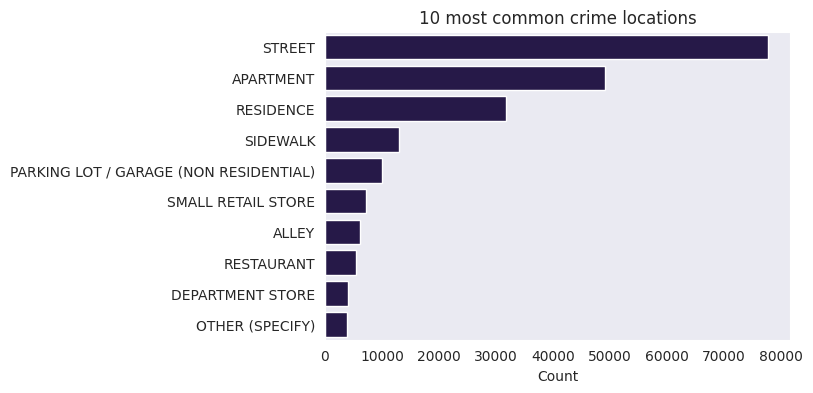

In [14]:
#Grouping the reports by location
location = df['unique_key'].groupby(df['location_description']).count().sort_values(ascending=False).head(10)
location = location.reset_index()
location['percentage'] = ((location['unique_key'] / location['unique_key'].sum()) * 100).round(2)

ax = plt.subplots(figsize=(6, 4))
sns.barplot(x=location['unique_key'], y=location['location_description'])
plt.title('10 most common crime locations')
plt.xlabel('Count')
plt.ylabel('')
plt.show()

In [15]:
#Calculating the percentage of crime reported in public spaces amongst the most frequent locations
street = df[df['location_description'] == 'STREET'].count()['unique_key']
sidewalk = df[df['location_description'] == 'SIDEWALK'].count()['unique_key']
pg = df[df['location_description'] == 'PARKING LOT/GARAGE(NON.RESID.)'].count()['unique_key']
alley = df[df['location_description'] == 'ALLEY'].count()['unique_key']

crimes_in_public_spaces = street + sidewalk + pg + alley

total_count_of_crimes = df['unique_key'].count()

percentage_of_crimes_in_public_spaces = (crimes_in_public_spaces / total_count_of_crimes) * 100

print(f"From the locations above, {percentage_of_crimes_in_public_spaces:.2f}% of crimes happend in public spaces.")

From the locations above, 36.88% of crimes happend in public spaces.


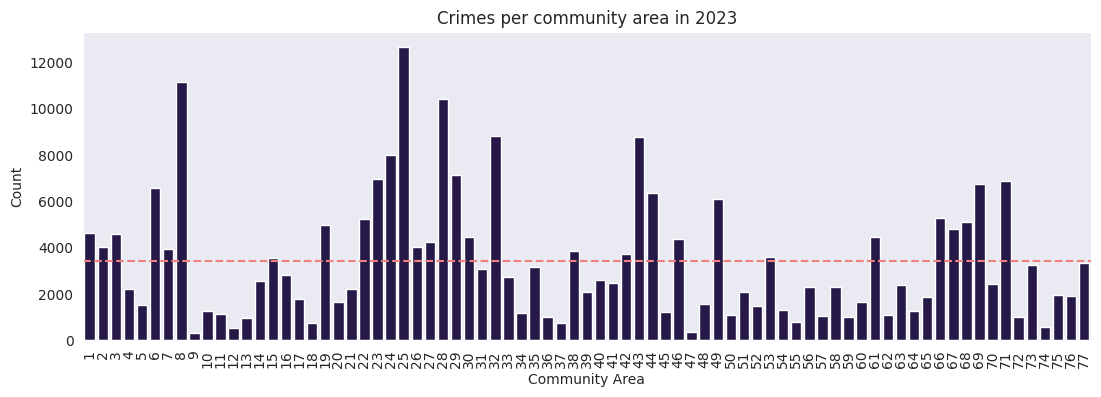

In [16]:
#Grouping the reports by community number
communities_2023 = df['unique_key'].groupby(df['community_area']).count().sort_values(ascending=False)
communities_2023 = pd.DataFrame(communities_2023)

sns.set_palette("magma")
fig, ax = plt.subplots(figsize=(13, 4))
plt.xticks(rotation=90)
ax = sns.barplot(data=communities_2023, x='community_area', y='unique_key')
plt.title('Crimes per community area in 2023')
plt.xlabel('Community Area')
plt.ylabel('Count')
plt.axhline(y=3409, color='lightcoral', linestyle='--')
plt.show()

Even though the ``community_area`` column has a lot of missing values, it is complete for all 2023 reports.
That allows us to analyse the distribution of crimes across Chicago in the past year. The city is divided into 77 communities and the ones where we can see the highest crime rates are the numbers 8, 25, 28, 32 and 43.

In [17]:
#Calculating the average number of incidents per community
crimes_2023 = df['unique_key'].count()

number_of_communities = df['community_area'][df['year'] == 2023].nunique()

average_crimes_per_community = crimes_2023 / number_of_communities

print(f"Average number of reported incidents of crime per communities: {average_crimes_per_community:.0f}")

Average number of reported incidents of crime per communities: 3409


In [18]:
#Calculating the sum of incidents related to the median value
communities_2023 = df['unique_key'].groupby(df['community_area']).count().sort_values(ascending=True)
communities_2023 = pd.DataFrame(communities_2023)
communities_2023 = communities_2023.reset_index()
communities_2023

first_half = communities_2023['unique_key'].tail(38).sum()/communities_2023['unique_key'].sum().round(2) * 100

median_value = np.median(communities_2023['unique_key'])

print(f"The second half of communities represent: {first_half:.2f} of the total number of reported crimes.")

The second half of communities represent: 78.49 of the total number of reported crimes.


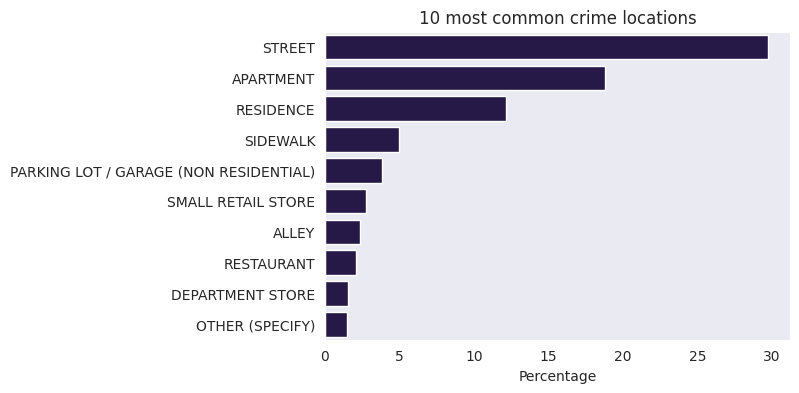

In [19]:
#Grouping the reports by location
location = df['unique_key'].groupby(df['location_description']).count().sort_values(ascending=False)
location = location.reset_index()
location['percentage'] = ((location['unique_key'] / location['unique_key'].sum()) * 100).round(2)
location = location.head(10)

ax = plt.subplots(figsize=(6, 4))
sns.barplot(x=location['percentage'], y=location['location_description'])
plt.title('10 most common crime locations')
plt.xlabel('Percentage')
plt.ylabel('')
plt.show()

In [20]:
location22 = location[location['location_description'].isin(["ALLEY", "STREET", "SIDEWALK", "PARKING LOT / GARAGE (NON RESIDENTIAL)"])]['percentage'].sum()
location22


40.89